In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable

In [69]:
data_dir = 'D:/Data/MoldPID/top/train-full'

class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

mnist_transforms=[
            transforms.Grayscale(),
            transforms.ToTensor()]
mnist_transforms.append(ReshapeTransform((-1,)))

test_transforms = transforms.Compose(mnist_transforms)


In [70]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(15 * 18, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 3) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
model = MNISTNet(100)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('pintopmodel-FC-S.pth'))
model.eval()
model

MNISTNet(
  (fc1): Linear(in_features=270, out_features=100, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

In [99]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

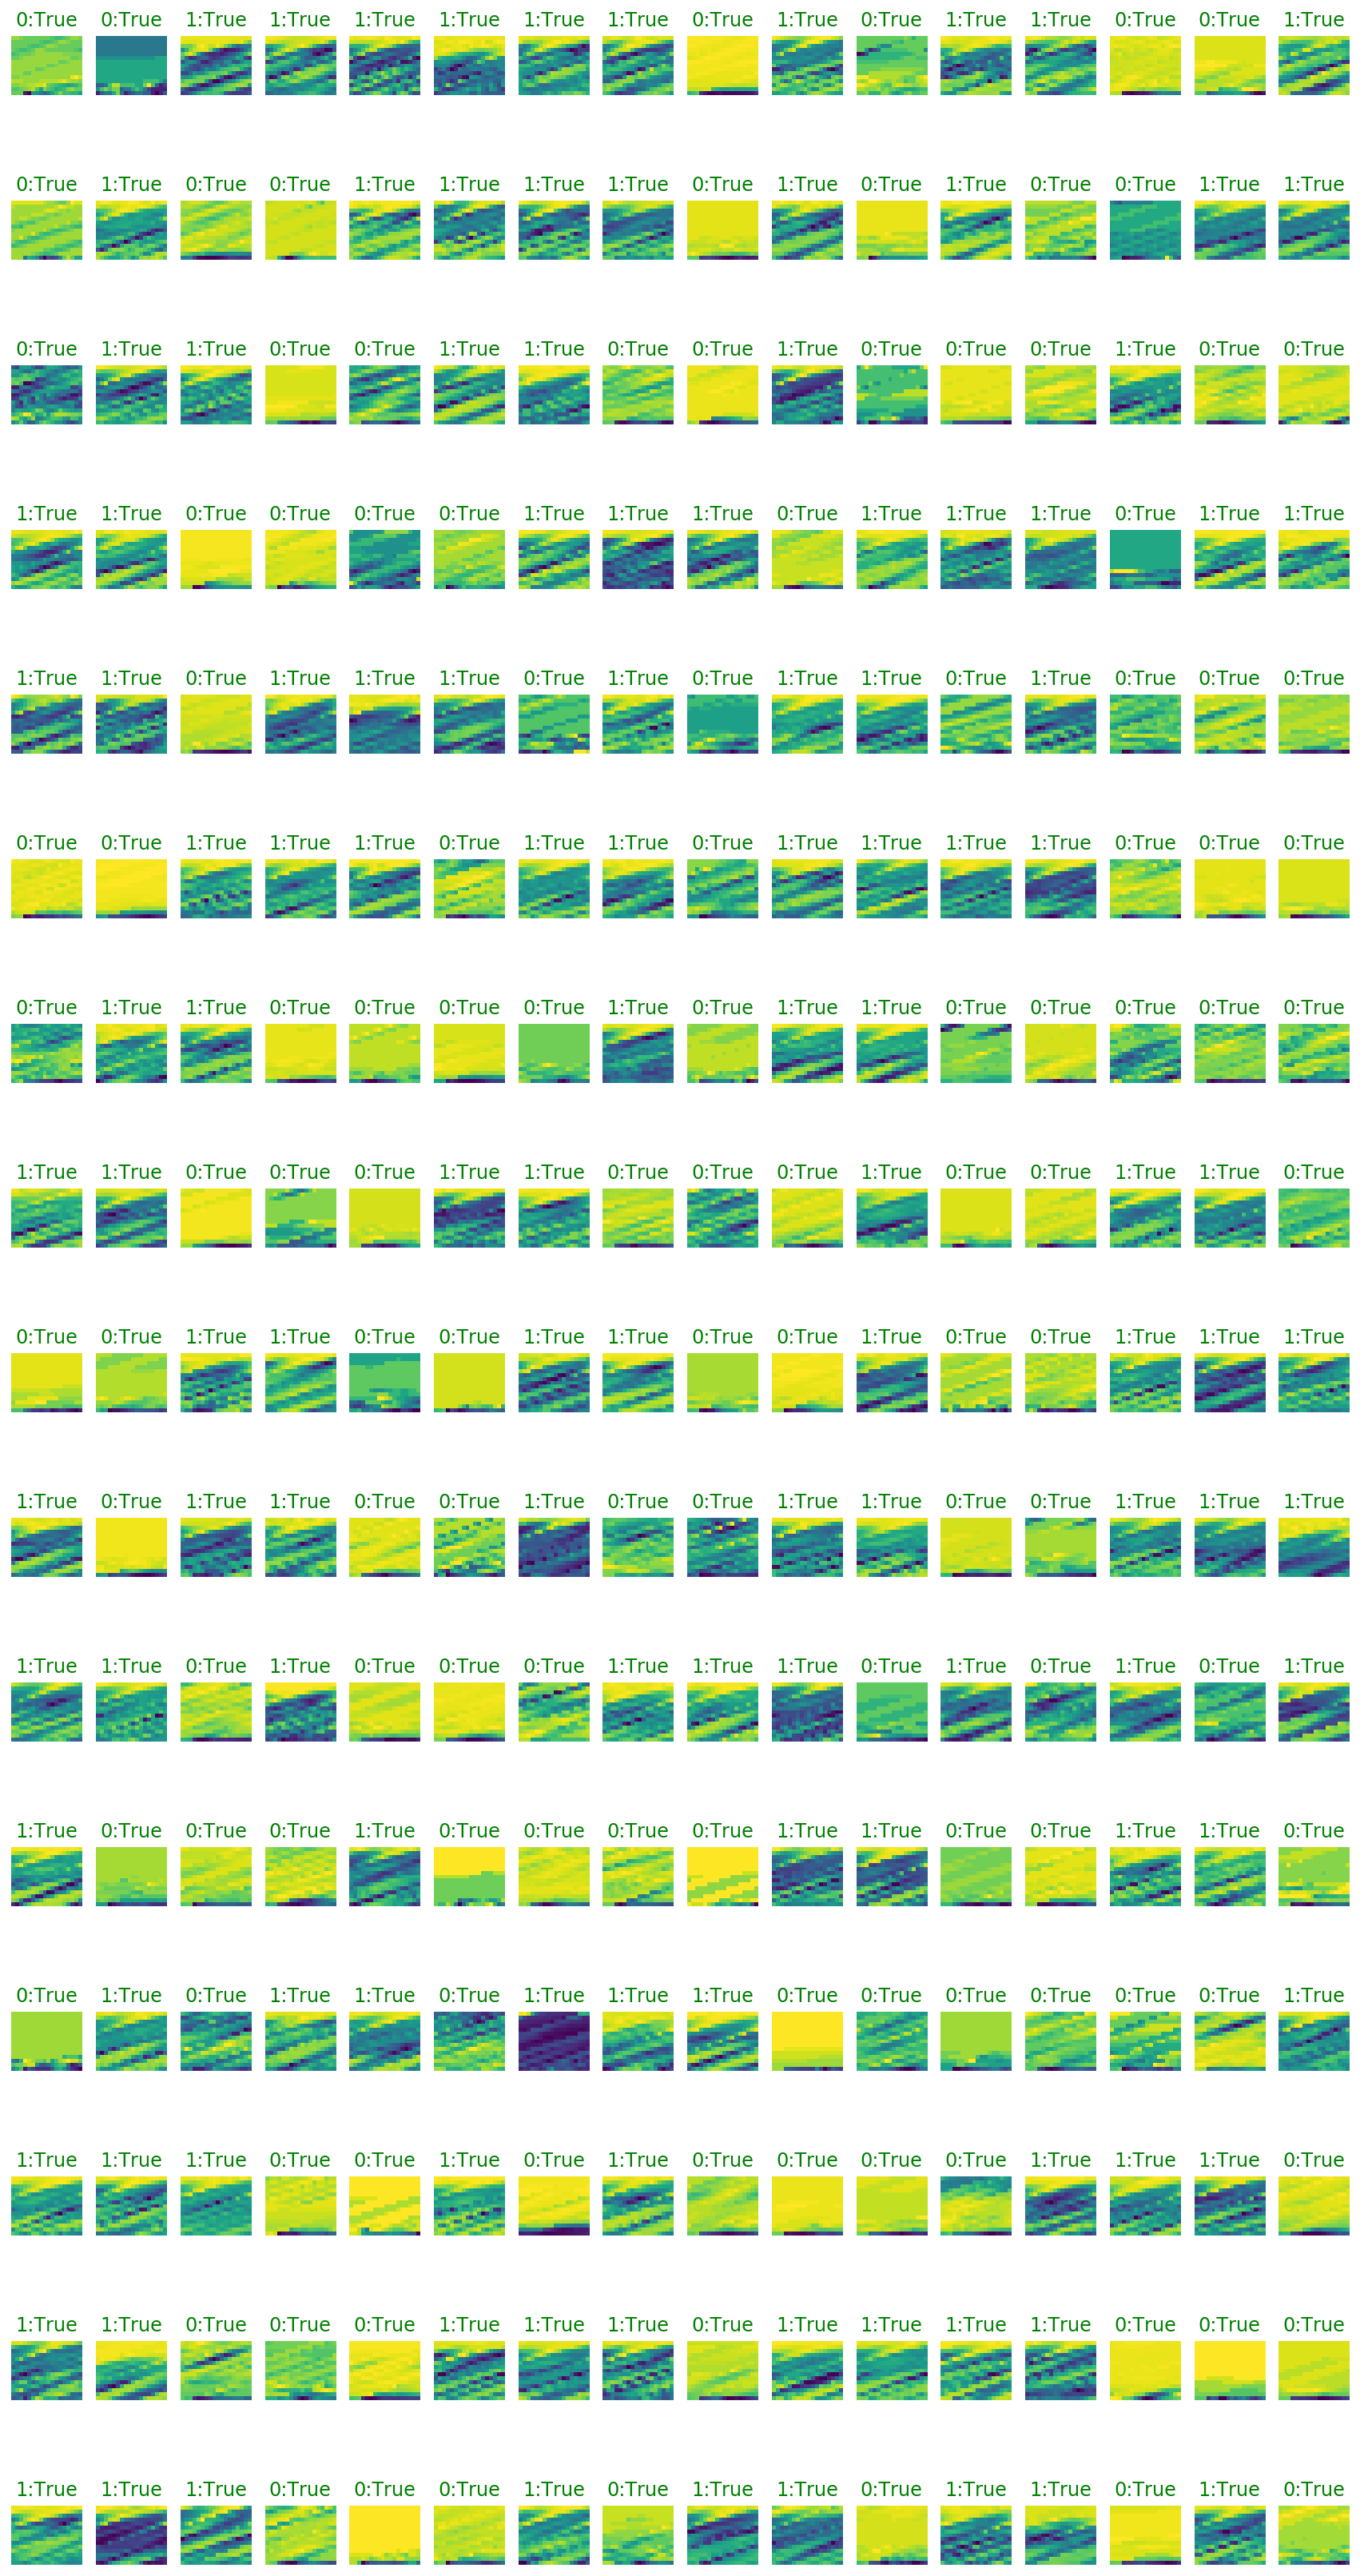

In [100]:
import matplotlib as mpl
to_pil = transforms.ToPILImage()
images, labels = get_random_images(256)
fig=plt.figure(figsize=(15,30))
for ii in range(len(images)):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    image_p = to_pil(images[ii].reshape(15, 18))
    index = predict_image(image_p)
    sub = fig.add_subplot(16, len(images) / 16, ii+1)
    res = int(labels[ii]) == index
    fontParams = {'fontsize': mpl.rcParams['axes.titlesize'],
                  'fontweight': mpl.rcParams['axes.titleweight'], 
                  'color': 'green',
                  'verticalalignment': 'baseline', 
                  'horizontalalignment': 'center'}
    if res == False:
        fontParams['color'] = 'red'
        print(fontParams)
    sub.set_title(str(classes[index]) + ":" + str(res), fontdict=fontParams)
    plt.axis('off')
    plt.imshow(images[ii].reshape(15, 18))
plt.show()

In [104]:
def save_net_as_cv_mat(filename, model_net):
    cv_file = cv2.FileStorage(filename, cv2.FILE_STORAGE_WRITE)
    cv_file.write("weights1", model_net.fc1.weight.data.numpy())
    cv_file.write("bias1", model_net.fc1.bias.data.numpy())
    cv_file.write("weights2", model_net.fc2.weight.data.numpy())
    cv_file.write("bias2", model_net.fc2.bias.data.numpy())
    cv_file.release()

In [105]:
save_net_as_cv_mat('fullconn_top.xml', model)

NameError: name 'cv2' is not defined